<!--
SPDX-FileCopyrightText: 2023 The eminus developers
SPDX-License-Identifier: Apache-2.0
-->
# Wannier localization

In [1]:
import pathlib

from eminus import Atoms, read, SCF
from eminus import backend as xp
from eminus.extras import view
from eminus.localizer import get_wannier, wannier_cost
from eminus.orbitals import FLO, SCDM, WO
from eminus.tools import orbital_center

In [2]:
# Run an initial calculation for methane
atoms = Atoms(*read("CH4.xyz"), ecut=15, center=True)
scf = SCF(atoms)
scf.run();

XYZ file comment: "Experimental geometry from CCCBDB: https://cccbdb.nist.gov/exp2x.asp?casno=74828&charge=0"
Start auto minimization...
Method  Iteration  Etot [Eh]    dEtot [Eh]   |Gradient|   
pccg           1   +18.061427   
pccg           2   +7.881450    -1.0180e+01  [+1.05e+04]  
pccg           3   +0.099586    -7.7819e+00  [+1.87e+03]  
pccg           4   -4.096798    -4.1964e+00  [+3.10e+02]  
pccg           5   -6.145812    -2.0490e+00  [+5.75e+01]  
pccg           6   -6.874551    -7.2874e-01  [+1.02e+01]  
pccg           7   -7.285784    -4.1123e-01  [+2.95e+00]  
pccg           8   -7.577908    -2.9212e-01  [+3.02e+00]  
pccg           9   -7.787117    -2.0921e-01  [+1.35e+00]  
pccg          10   -7.857628    -7.0510e-02  [+2.89e-01]  
pccg          11   -7.875693    -1.8065e-02  [+6.94e-02]  
pccg          12   -7.879606    -3.9137e-03  [+1.64e-02]  
pccg          13   -7.880591    -9.8423e-04  [+4.26e-03]  
pccg          14   -7.880813    -2.2256e-04  [+9.53e-04]  
pccg

In [3]:
# Calculate the SCDMs to have pre-localized orbitals
scdm = SCDM(scf)

In [4]:
# Do the Wannier localization
# The resulting orbitals are equivalent to Foster-Boys orbitals, but with periodic boundary conditions
wannier = get_wannier(atoms, scdm)

Wannier localizer converged after 15 iterations.


In [5]:
# Compare the initial SCDM spreads to the Wannier spreads
scdm_spreads = wannier_cost(atoms, scdm)
print(f"\nSCDM spreads = {scdm_spreads}")
print(f"SCDM spread = {xp.sum(scdm_spreads)}")

Costs:
tensor([2.6073, 2.6631, 2.7152, 2.7639])

SCDM spreads = tensor([[2.6073, 2.6631, 2.7152, 2.7639]])
SCDM spread = 10.7495258170228


In [6]:
# The Wannier orbitals are a bit more localized, and all orbitals are evenly localized
wannier_spreads = wannier_cost(atoms, wannier)
print(f"Wannier spreads = {wannier_spreads}")
print(f"Wannier spread = {xp.sum(wannier_spreads)}")

Costs:
tensor([2.6821, 2.6821, 2.6821, 2.6821])
Wannier spreads = tensor([[2.6821, 2.6821, 2.6821, 2.6821]])
Wannier spread = 10.72830226032869


In [7]:
# All of the above can be done with one function call, also save the orbitals
WO(scf, write_cubes=True);

Wannier localizer converged after 15 iterations.
Write CH4_WO_k0_0.cube...
Write CH4_WO_k0_1.cube...
Write CH4_WO_k0_2.cube...
Write CH4_WO_k0_3.cube...


In [8]:
# Display the orbitals from the cube files
view(pathlib.Path().glob("*.cube"));

/home/wangenau/Documents/eminus/.venv/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/wangenau/Documents/eminus/.venv/lib/python3.12/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


interactive(children=(Dropdown(description='filename', options=('CH4_WO_k0_2.cube', 'CH4_WO_k0_1.cube', 'CH4_W…

/home/wangenau/Documents/eminus/.venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:193: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword

/home/wangenau/Documents/eminus/.venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:120: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword

/home/wangenau/Documents/eminus/.venv/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:49: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword

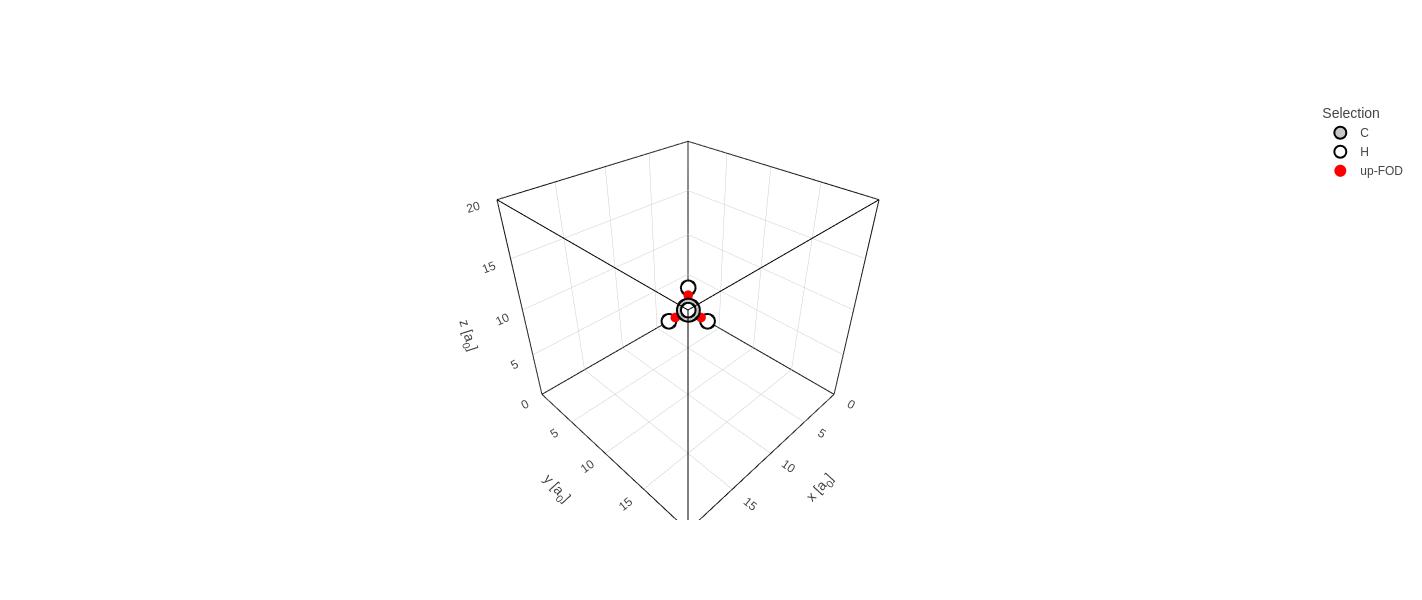

In [9]:
# One could calculate the center of masses from the Wannier orbitals...
coms = orbital_center(atoms, wannier[0])
atoms.view(coms)

In [10]:
# ...and use them as an initial guess to create a set of FLOs
flo = FLO(scf, fods=coms)
flo_spreads = wannier_cost(atoms, flo)
print(f"FLO spreads = {flo_spreads}")
print(f"FLO spread = {xp.sum(flo_spreads)}")

Costs:
tensor([3.5156, 3.6412, 3.8532, 4.5234])
FLO spreads = tensor([[3.5156, 3.6412, 3.8532, 4.5234]])
FLO spread = 15.533380985078622
